In [ ]:
!pip install pyspark py4j

# Data - UCI Irvine ML Repository and EDA

In [3]:
import numpy as np
import pandas as pd
from math import sqrt
import seaborn as sns
from collections import Counter
from operator import getitem
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.functions import mean as mean_ # just to avoid name conflicts
from pyspark.sql.functions import stddev as stddev_ # just to avoid name conflicts

I decided to download the iris dataset from the above reference (this is from Final Project – Spark Project). After downloading the data from UCI Irvine Machine learning Repository, I ended up having 4 datasets: bezdekIris.data, Index, iris.data, iris.names. I decided to load “iris.data” into Excel and use the “Convert Text to Columns Wizard Delimited Option” within the “Text to Columns” section in “Data” tab.

I saved the file as a csv file; however I ended up getting missing features. Due to this I finally decided to store the file as an excel file. Column 1 to Column 4 -> General Data and Column 5 (class) -> Text Data.

`iris.names:`

- Number of Instances: 150 (50 in each of three classes)

- Number of Attributes: 4 numeric, predictive attributes and the class

- Attribute Information:
   1. sepal length in cm
   2. sepal width in cm
   3. petal length in cm
   4. petal width in cm
   5. class:
      -- Iris Setosa
      -- Iris Versicolour
      -- Iris Virginica

- Missing Attribute Values: None

- Class Distribution: 33.3% for each of 3 classes.

`UCI Irvine ML Rep.:`

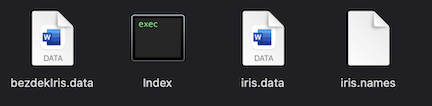

Run the above code just once (if you don't have the iris csv file):

In [ ]:
#excel = pd.read_excel('iris_dataset.xlsx')
#excel.head()

,sepal length in cm,sepal width in cm,petal length in cm,petal width in cm,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


Now lets convert the excel file into a csv file so we can eventually use the data in Spark.

In [4]:
#excel.to_csv ('iris_dataset.csv', index = None, header = True)
df_csv = pd.read_csv('iris_dataset.csv')
df_csv.head()

,sepal length in cm,sepal width in cm,petal length in cm,petal width in cm,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [5]:
df_csv.size

750

In [6]:
df_csv.shape

(150, 5)

In [7]:
df_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sepal length in cm  150 non-null    float64
 1   sepal width in cm   150 non-null    float64
 2   petal length in cm  150 non-null    float64
 3   petal width in cm   150 non-null    float64
 4   class               150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [8]:
missing = df_csv.isnull() # checking for missing values
count_missing = missing.sum()
print(count_missing)

sepal length in cm    0
sepal width in cm     0
petal length in cm    0
petal width in cm     0
class                 0
dtype: int64


In [9]:
df_csv.describe() # matches with the summary statistic from the "iris.names"

,sepal length in cm,sepal width in cm,petal length in cm,petal width in cm
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


**Some data Visualization**

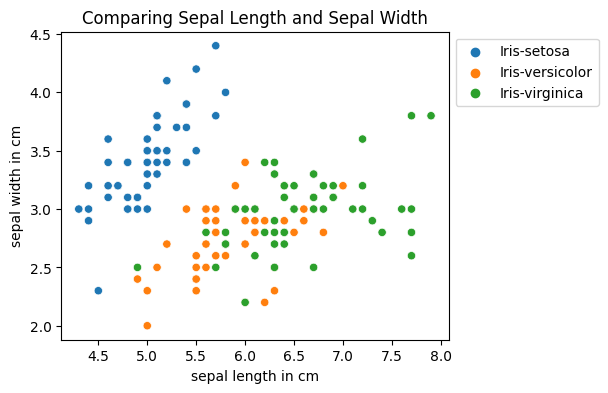

In [10]:
plt.figure(figsize=(5, 4))

sns.scatterplot(x ='sepal length in cm', y ='sepal width in cm', hue ='class', data = df_csv, )
plt.legend(bbox_to_anchor = (1, 1), loc = 2)
plt.title('Comparing Sepal Length and Sepal Width')

plt.show()

The above plot shows that class Setosa has smaller sepal length, but larger sepal width. Versicolor is between the other 2 classes in terms of sepal lengths and widths. Virginica is the class that has larger lengths, but smaller widths.

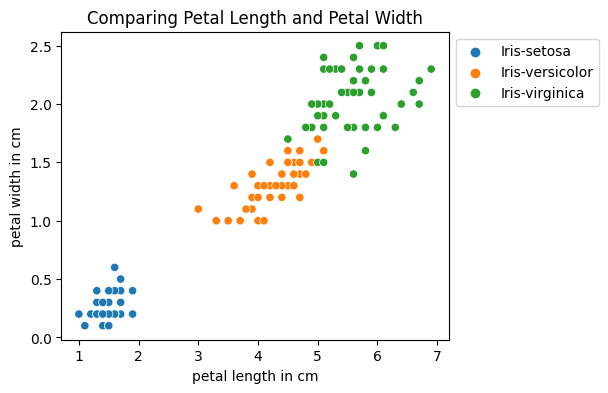

In [11]:
plt.figure(figsize=(5, 4))

sns.scatterplot(x ='petal length in cm', y ='petal width in cm', hue ='class', data = df_csv, )
plt.legend(bbox_to_anchor = (1, 1), loc = 2)
plt.title('Comparing Petal Length and Petal Width')

plt.show()

This plot shows that Setosa has the smaller petal lengths and widths. Again. Versicolor lies in between, but its superior to Setosa in term of petal lengths and widths. Finally, the plot shows that class Virginica has the largest measurements for petal lengths and widths.

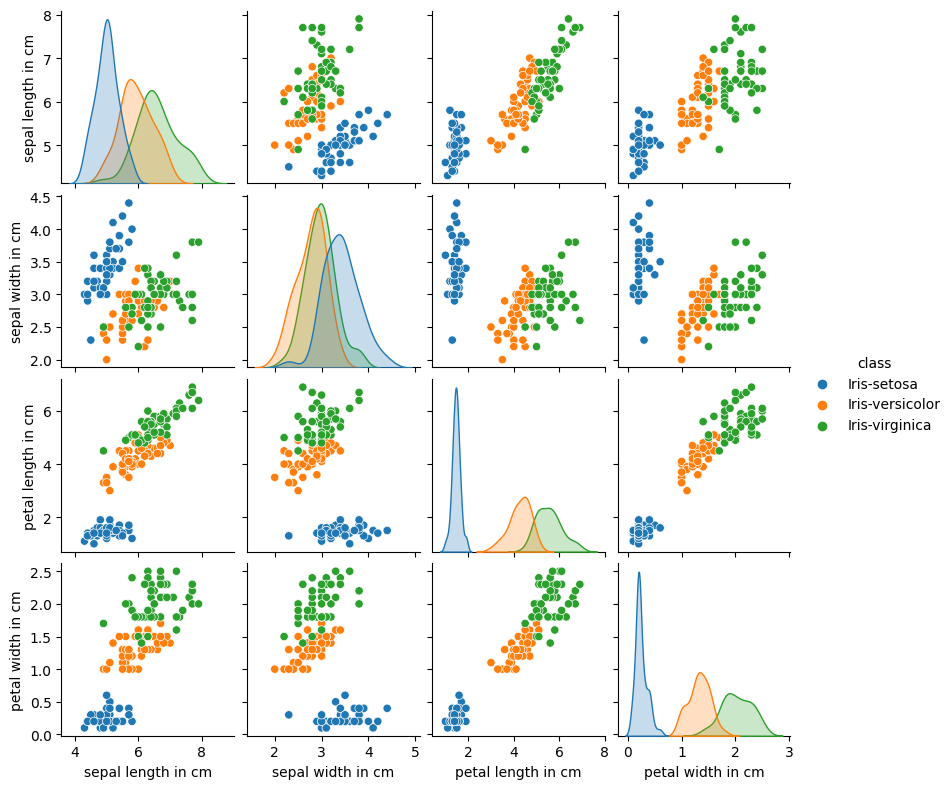

In [12]:
sns.pairplot(df_csv, hue = 'class', height = 2) # column relationship using pairplot

In [ ]:
#!pip install pandas-profiling -> Phase 2 Applied Machine Learning submission

In [49]:
#from pandas_profiling import ProfileReport -> Phase 2 Applied Machine Learning submission

In [ ]:
# I don't this is neccessary:

#profile_iris = ProfileReport(df_csv, title='Iris Dataset', explorative=True) # Phase 2 Applied Machine Learning submission
#profile_iris

# PySpark - Data EDA, Splitting, and Preprocessing

In [5]:
spark = SparkSession.builder.appName('DataFrame').getOrCreate()

## Step 1 Reading CSV

Function that reads the data using Spark data frames and basic EDA. This custom function came from previous HomeWorks. It contains `spark.read.option()` and it’s also design to read the show the top 5 rows just like `df.head()`. This last step can also be edited to show the numbers of rows you want.

In [6]:
def pyspark_csv_reader(csv):  # spark session object and csv file
    df = spark.read.option('header', 'true').csv(csv) # previous hmw
    df.show(n = 5, truncate = False) # previous hmw
    return df # return df with 5 rows. This can be change

In [7]:
df = pyspark_csv_reader('iris_dataset.csv') # apply the function

+------------------+-----------------+------------------+-----------------+-----------+
|sepal length in cm|sepal width in cm|petal length in cm|petal width in cm|class      |
+------------------+-----------------+------------------+-----------------+-----------+
|5.1               |3.5              |1.4               |0.2              |Iris-setosa|
|4.9               |3.0              |1.4               |0.2              |Iris-setosa|
|4.7               |3.2              |1.3               |0.2              |Iris-setosa|
|4.6               |3.1              |1.5               |0.2              |Iris-setosa|
|5.0               |3.6              |1.4               |0.2              |Iris-setosa|
+------------------+-----------------+------------------+-----------------+-----------+
only showing top 5 rows



In [8]:
df.printSchema()

root
 |-- sepal length in cm: string (nullable = true)
 |-- sepal width in cm: string (nullable = true)
 |-- petal length in cm: string (nullable = true)
 |-- petal width in cm: string (nullable = true)
 |-- class: string (nullable = true)



In [9]:
count_rows = df.count() # PySpark count method
count_columns = len(df.columns)
print('The number of rows in the PySpark DataFrame is:', count_rows)
print('The number of columns in the PySpark DataFrame is:', count_columns)

The number of rows in the PySpark DataFrame is: 150
The number of columns in the PySpark DataFrame is: 5


When we load the Iris csv dataset (above using Pandas), we checked for missing values which returned 0 for each column. We know this is a small dataframe with just 150 rows, however lets drop the duplicates just for the sake of good practices. Even though dropping duplicates might affect results in a good way, I am not sure how much efect will have in this small dataset.

In [10]:
duplicates = df.groupBy(df.columns).count().where(col('count') > 1) # group by all columns for duplicate rows
duplicates = duplicates.count()

print('Number of duplicate rows:', duplicates)

Number of duplicate rows: 2


In [11]:
df.dropDuplicates() # lets remove the duplicates

DataFrame[sepal length in cm: string, sepal width in cm: string, petal length in cm: string, petal width in cm: string, class: string]

In [12]:
df.describe().show()

+-------+------------------+-------------------+------------------+------------------+--------------+
|summary|sepal length in cm|  sepal width in cm|petal length in cm| petal width in cm|         class|
+-------+------------------+-------------------+------------------+------------------+--------------+
|  count|               150|                150|               150|               150|           150|
|   mean| 5.843333333333335| 3.0540000000000007|3.7586666666666693|1.1986666666666672|          null|
| stddev|0.8280661279778637|0.43359431136217375| 1.764420419952262|0.7631607417008414|          null|
|    min|               4.3|                2.0|               1.0|               0.1|   Iris-setosa|
|    max|               7.9|                4.4|               6.9|               2.5|Iris-virginica|
+-------+------------------+-------------------+------------------+------------------+--------------+



In [13]:
df.groupBy('class').count().show()

+---------------+-----+
|          class|count|
+---------------+-----+
| Iris-virginica|   50|
|    Iris-setosa|   50|
|Iris-versicolor|   50|
+---------------+-----+



## Step 2 - Randomly Splitting the data

Randomly divide the data into three sets such that one set has around 60% data sample and the other two have 20% data sample each. 60% data will go to the training set, 20% to the validation set, and another 20% will go to the test set. Since we are not using SKLearn to train_test_split the data, we have to find another solution to this task (random division). We are going to random split the data using the randomSplit() method from PySpark. Also, seed = 42 is added just to mimic the SKlearn random_state = 42.

In [14]:
train_set, validation_set, test_set = df.randomSplit([0.6, 0.2, 0.2], seed = 42)

## Step 3 - Normalizing the data

The features_columns is a list that contains the name of the value we wish to Normalize:

In [15]:
# feature columns
feature_columns = ['sepal length in cm', 'sepal width in cm', 'petal length in cm', 'petal width in cm']

Let’s calculate and collect the mean and std values for each column within the feature_columns. The technique we are using here to normalize the data will transform the features values from those coumns to a scale where the mean is 0 and the std is 1. This will help our model to actually learn and get better results. We are doing this because we have different sepal and petal lengths and widths range values. Let’s say we decide to feed the KNN model this data without normalization. The model might give mixed results, because it might take sepal vs petal lengths and favor the petal lengths for being bigger values (KNN might favor features with larger values). We must normalize the data to have a better performance and more accurate results.

The code `train_set.agg({column: ‘mean’}).collect()[0][0]`calculates the aggregate mean of the passed parameter set (train_set) and
the code `train_set.agg({column: ‘stddev’}).collect()[0][0]` calculate the aggregate std of the passed parameter set (train_set).

We finally use the `collect()[0][0]` to collect the values and store them in variables. The sets: train, validation, and test sets are the result of subtracting the mean of the respective column from each cell, and dividing that with the standard deviation of that column. It is also important to state that we need to normalize the evaluation and testing sets (new unseen data) using the mean and std of the training set.

In [16]:
def normalize_data(train_set, validation_set, test_set, feature_columns):
    for column in feature_columns:
        mean_value = train_set.agg({column: 'mean'}).collect()[0][0]
        std_value = train_set.agg({column: 'stddev'}).collect()[0][0]

        train_set = train_set.withColumn(column, (col(column) - mean_value) / std_value) # substract mean and devide with std
        validation_set = validation_set.withColumn(column, (col(column) - mean_value) / std_value)  # substract mean and devide with std
        test_set = test_set.withColumn(column, (col(column) - mean_value) / std_value)  # substract mean and devide with std

    return train_set, validation_set, test_set

In [17]:
train_set, validation_set, test_set = normalize_data(train_set, validation_set, test_set, feature_columns)

## Step 4 - Retrieve "class" column

Using `collect()` method to retrieve the data.

Retrieve “class” column form the train_set, validation_set, and test_set. Store values in separate lists that will help us make predictions later on.

In [18]:
train_labels = [row['class'] for row in train_set.select('class').collect()]

validation_labels = [row['class'] for row in validation_set.select('class').collect()]

test_labels = [row['class'] for row in test_set.select('class').collect()]

# Euclidean Distance Function:

In [19]:
def euclidean_distance(row1, row2):
    distance = 0
    for column in feature_columns:
        distance += (row1[column] - row2[column]) ** 2
        result = sqrt(distance)
    return result

# KNN Algorithm

Even though the KNN Algorithm can be used for both classification and regression, this task is a multi-classification problem. In this Iris dataset, the column “class” is our categorical data containing 2 different 3 different classes: Setosa, Vericolor, and Virginica.

Our goal here is to try and predict classes.

Even though this is a simple implementation, this algorithm suffers from many limitations like it is: computationally expensive, sensitive to noise, and requires a careful selection of k.


## Step 1 - Calculating the Euclidean distance and Fetch K Nearest Neighbors

The function does the following:

- For each row in the validation data set, it calculates the Euclidean distance to every row in the training set.

- Once we have all the distances, select the k minimum distance with each row of the train set. We will sort the Euclidean distance for each validation row in ascending order (taking into account the “class” label for each training row). We will sort using Lambda here.

- Stores tuples of the “class “labels for the k nearest training set neighbors for each validation row.

- Perform list slicing. Selects K values (nearest neighbors) for each validation row and adds them to distance list. Different k values will influence our model’s prediction, reason why we have to test different k values (hyper parameter tuning – Applied Machine Learning).

In [20]:
def Fetch_Neighbours(train_set, validation_set, k):
    distances = []
    for validation_row in validation_set.collect():
        row_distances = []
        for train_row in train_set.collect():
            euc_dist = euclidean_distance(validation_row, train_row)
            row_distances.append((euc_dist, train_row['class']))
        row_distances.sort(key=lambda x: x[0])  # sort by distance
        distances.append(getitem(row_distances, slice(0, k)))  # get the k nearest neighbors
    return distances

In [21]:
k = 10  # You can try k = 10, 15, 20, 25
neighbors = Fetch_Neighbours(train_set, validation_set, k)

In [23]:
for neighbors_row in neighbors:
    df_n = pd.DataFrame(neighbors_row)

In [24]:
df_n.head()

,0,1
0,0.409914,Iris-virginica
1,1.211044,Iris-virginica
2,1.756402,Iris-virginica
3,1.777245,Iris-virginica
4,1.905283,Iris-virginica


## Step 2 - Predictions

The `most_common_class` function uses the Python Counter approach. This approach basically returns the count of each element in the list.

The function `predict_classes` takes the above “neighbors” list and for each row of this list, it will extract the second element (class label) from each row in the list by doing list comprehension. You can view a small DataFrame above which displays the first and second element of the neighbors list.

We also apply the `most_common_class` function within the `predict_classes` function to get the most common “class” label for that row of neighbors. Finally, we store the prediction results in a list called “predictions”.

In [25]:
def most_common_class(List):
    occurrence_count = Counter(List)
    common_class = occurrence_count.most_common(1)[0][0]
    return common_class

def predict_classes(neighbors):
    predictions = [most_common_class([n[1] for n in neighbors_row]) # n for elememt iterration (list comprehension)
                   for neighbors_row in neighbors]
    return predictions

In [26]:
predictions = predict_classes(neighbors)
#print(predictions)

## Step 3 - Validation Accuracy Reporting

In [27]:
def accuracy_score(pred, y_test):
    count = 0
    for i in range(len(pred)):
        if pred[i] == y_test[i]:
            count += 1
    accuracy = (count / len(pred)) * 100
    return accuracy

In [28]:
accuracy_validation = accuracy_score(predictions, validation_labels)
accuracy_validation = round(accuracy_validation, 3)
print('The accuracy score for KNN validation is:', accuracy_validation)

The accuracy score for KNN validation is: 97.436


**The k values:**

k = 5 -> 97.436

k = 10 -> 97.436

k = 15 -> 94.872

k = 20 -> 94.872

k = 25 -> 92.308

k = 35 -> 89.744

## Step 4 - Testing Accuracy Reporting

In [29]:
# k = 10 using this value because it gave the max accuracy score from all the k values

test_neighbors = Fetch_Neighbours(train_set, test_set, k)
test_predictions = predict_classes(test_neighbors)

In [30]:
test_accuracy = accuracy_score(test_predictions, test_labels)
test_accuracy = round(test_accuracy, 3)
print('The accuracy score for KNN on the test set is:', test_accuracy)

The accuracy score for KNN on the test set is: 95.833


## Step 5 - Visualizing results

In [32]:
results1 = []
for predicted_label, actual_label in zip(test_predictions, test_labels):
    results1.append({'KNN Model Predicted Labels (k=10)': predicted_label,
                     'Actual Labels from Iris Dataset': actual_label})

df_results1 = pd.DataFrame(results1)
df_results1.head()

,KNN Model Predicted Labels (k=10),Actual Labels from Iris Dataset
0,Iris-setosa,Iris-setosa
1,Iris-setosa,Iris-setosa
2,Iris-setosa,Iris-setosa
3,Iris-setosa,Iris-setosa
4,Iris-setosa,Iris-setosa


The following code will display the wrong classification for the iris classes:

In [33]:
results2 = []
for predicted_label, actual_label in zip(test_predictions, test_labels):
    if predicted_label != actual_label:  # if predicted not equal to actual return the following:
        results2.append({'Predicted Labels (k=10)': predicted_label, 'Actual Labels': actual_label})

df_results2 = pd.DataFrame(results2)
df_results2

,Predicted Labels (k=10),Actual Labels
0,Iris-virginica,Iris-versicolor


# References:

- From excel to csv: https://www.geeksforgeeks.org/convert-excel-to-csv-in-python/

- Basic Python stuff: https://note.nkmk.me/en/python-pandas-nan-judge-count/

- Visualizations: https://www.geeksforgeeks.org/exploratory-data-analysis-on-iris-dataset/

- KNN Python: https://deepnote.com/@ndungu/Implementing-KNN-Algorithm-on-the-Iris-Dataset-e7c16493-500c-4248-be54-9389de603f16

- spark.createDataFrame: https://sparkbyexamples.com/pyspark/different-ways-to-create-dataframe-in-pyspark/?expand_article=1

- EDA in PySpark: https://medium.com/@aieeshashafique/exploratory-data-analysis-using-pyspark-dataframe-in-python-bd55c02a2852

- PySpark groupby count: https://sparkbyexamples.com/pyspark/pyspark-groupby-count-explained/

- PySpark drop duplicates: https://spark.apache.org/docs/3.1.2/api/python/reference/api/pyspark.sql.DataFrame.dropDuplicates.html

- Splitting data: https://towardsdatascience.com/data-splitting-technique-to-fit-any-machine-learning-model-c0d7f3f1c790#:~:text=If%20the%20size%20of%20our,1%20or%2099%3A0.5%3A0.5

- Feature Engineering: https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/

- PySpark AGG: https://www.geeksforgeeks.org/how-to-find-the-sum-of-particular-column-in-pyspark-dataframe/

- PySpark randomSplit()/collect(): https://www.geeksforgeeks.org/pyspark-randomsplit-and-sample-methods/

- Splitting PySpark DF: https://lifewithdata.com/2022/07/29/how-to-create-a-training-validation-and-test-set-in-pyspark/

- PySpark withColumn: https://sparkbyexamples.com/pyspark/pyspark-withcolumn/?expand_article=1

- Collect(): https://sparkbyexamples.com/pyspark/pyspark-collect/?expand_article=1

- Collect(): https://datascienceparichay.com/article/pyspark-dataframe-collect/

- Collect(): https://stackoverflow.com/questions/33224740/best-way-to-get-the-max-value-in-a-spark-dataframe-column

- PySpark select df: https://sparkbyexamples.com/pyspark/select-columns-from-pyspark-dataframe/

- Euclidean Distance function: https://machinelearningmastery.com/tutorial-to-implement-k-nearest-neighbors-in-python-from-scratch/

- Sort using Lambda: https://sparkbyexamples.com/python/sort-using-lambda-in-python/?expand_article=1

- Labmda operation: https://stackoverflow.com/questions/62208185/what-does-arr-sortkey-lambda-x-x0-x1-mean

- operator.getitem(),slice() methods: https://www.geeksforgeeks.org/python-k-elements-slicing/

- Spark ML using Scala: https://blog.sparker0i.me/spark-machine-learning-knn/

- KNN SKlearn: https://sparkbyexamples.com/machine-learning/k-nearest-neighborsk-nn-in-machine-learning/?expand_article=1

- KNN from scratch accuracy score: https://medium.com/analytics-vidhya/knn-implementation-from-scratch-96-6-accuracy-python-machine-learning-31ba66958644

- Predicted Values vs Actual Values: https://stackoverflow.com/questions/57374409/how-to-print-the-predicted-values-using-zip